0.00017947336268325266
Simulating Type Ia supernova with:
  Redshift (z): 0.1
  Absolute B magnitude: 20.0
  Stretch (x1): 0.5
  Color (c): 0.0
  Amplitude (x0): 0.000179

Simulating light curve...
SNR: 16.692439734104322
Plotting light curve...


/var/folders/0r/_1bnthz146q2xj0c42f4nl_80000gq/T/ipykernel_40211/3792760410.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + lc['zp'][mask]


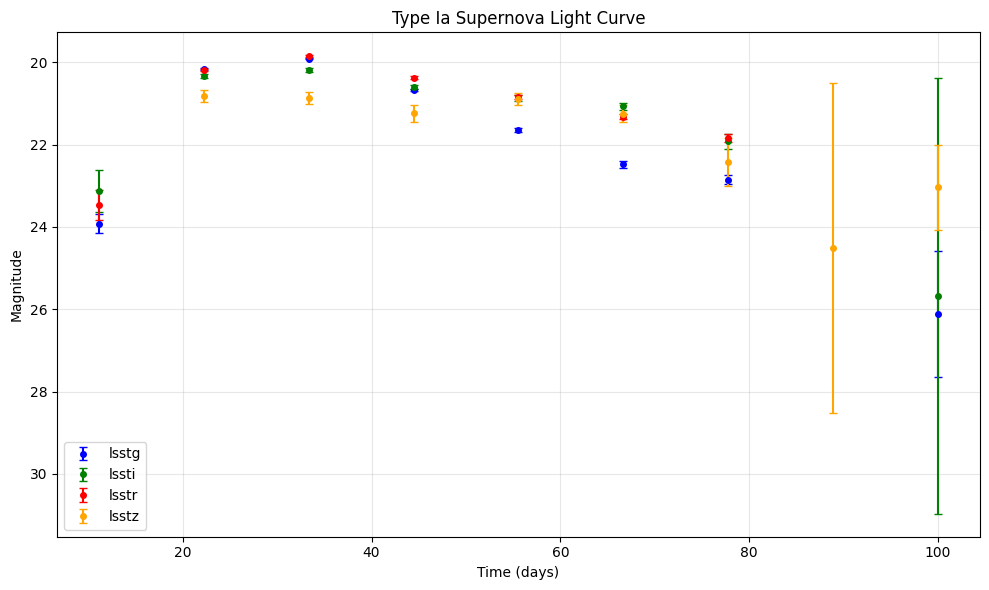

In [18]:
import numpy as np
import sncosmo
from astropy.table import Table
import matplotlib.pyplot as plt

times = np.linspace(0.1,100,100) # days
wavelengths = np.linspace(2000,12000,10) # Angstroms

num_points = 10
time_points = np.linspace(0.01,100, num_points) # to observe
num_points = len(time_points)

bands = ['lsstg', 'lsstr', 'lssti', 'lsstz']

# zeropoints from https://smtn-002.lsst.io/
zeropoints = [28.51, 28.36, 28.17, 27.78]
# LSST sky brightness in mag/arcsec^2 (from SMTN-002 official values)
sky_brightness_mag = [22.25, 21.2, 20.46, 19.61]  # g, r, i, z bands

# LSST observing parameters (from official LSST specs)
exptime = 30.0  # seconds per visit (2x15s exposures)
pixel_scale = 0.2  # arcseconds per pixel (LSST camera)
aperture_radius = 1.0  # arcseconds (typical PSF aperture, will be calculated properly)
read_noise = 8.8  # electrons per pixel per exposure
dark_current = 0.2  # electrons per pixel per second
num_bands = len(bands)

# Convert sky brightness to sky noise (electrons/pixel/second)
# Using LSST effective area = 6.423m diameter, pixel scale = 0.2 arcsec/pixel
# Sky noise = sky_flux * effective_area * pixel_area / exposure_time
# For now, using approximate values - these should be calculated more precisely
sky_noise = 10**(-0.4*(np.asarray(sky_brightness_mag) - np.asarray(zeropoints))) * pixel_scale**2  # g, r, i, z bands (electrons/pixel/second)


ia_obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':np.repeat(sky_noise, num_points),
             'exptime': exptime * np.ones(num_points*num_bands),
             'pixel_scale': pixel_scale * np.ones(num_points*num_bands),
             'aperture_radius': aperture_radius * np.ones(num_points*num_bands),
             'read_noise': read_noise * np.ones(num_points*num_bands),
             'dark_current': dark_current * np.ones(num_points*num_bands)})

def get_x0(mb):
    return 10**(-(mb-10.635)/2.5)

def simulate_ia(true_z, t0, x0, x1, c):
    params = {'z': true_z, 't0': t0, 'x0':x0, 'x1': x1, 'c':c}
    
    ia_source = sncosmo.get_source('salt2', version='B22')
    
    this_ia_model = sncosmo.Model(source=ia_source)

    lcs = sncosmo.realize_lcs(ia_obs, this_ia_model, [params])
    r_band_mask = lcs[0]['band'] == 'lsstr'
    snr = np.mean(np.abs(lcs[0]["flux"][r_band_mask]) / lcs[0]["fluxerr"][r_band_mask])
    print("SNR:", snr)

    return lcs

def fit_ia(true_z, lcs):    
    ia_source = sncosmo.get_source('salt2', version='B22')
    
    this_ia_model = sncosmo.Model(source=ia_source)
    
    this_ia_model.set(z = true_z)
    
    result, fitted_model = sncosmo.fit_lc(lcs[0], this_ia_model,
    ['t0', 'x0', 'x1', 'c'], minsnr = 1., guess_z = False, bounds={'x0':(0, 0.1), 'x1':(-3, 2), 'c':(-1, 1)})
    
    return result, fitted_model

def plot_light_curve(lc):
    """
    Plot the light curve in different bands
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Get unique bands
    bands = np.unique(lc['band'])
    colors = ['blue', 'green', 'red', 'orange']
    
    for i, band in enumerate(bands):
        mask = lc['band'] == band
        time = lc['time'][mask]
        flux = lc['flux'][mask]
        fluxerr = lc['fluxerr'][mask]
        
        # Convert flux to magnitude
        mag = -2.5 * np.log10(flux) + lc['zp'][mask]
        magerr = np.abs(2.5 / np.log(10) * fluxerr / flux)
        
        ax.errorbar(time, mag, yerr=magerr, fmt='o', 
                   label=f'{band}', color=colors[i % len(colors)], 
                   capsize=3, markersize=4)
    
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Magnitude')
    ax.set_title('Type Ia Supernova Light Curve')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()  # Brighter objects have lower magnitudes
    
    plt.tight_layout()
    plt.show()

def main():
    """
    Main function to simulate a Type Ia supernova and fit its light curve
    """
    # Define supernova parameters
    true_z = 0.1  # redshift
    t0 = 30.0      # time of maximum brightness
    mb = 20.0    # absolute B-band magnitude
    x0 = get_x0(mb)  # amplitude parameter
    x1 = 0.5      # stretch parameter
    c = 0.0       # color parameter
    print(x0)
    
    print(f"Simulating Type Ia supernova with:")
    print(f"  Redshift (z): {true_z}")
    print(f"  Absolute B magnitude: {mb}")
    print(f"  Stretch (x1): {x1}")
    print(f"  Color (c): {c}")
    print(f"  Amplitude (x0): {x0:.6f}")
    print()
    
    # Simulate the light curve
    print("Simulating light curve...")
    lcs = simulate_ia(true_z, t0, x0, x1, c)
    
    # Plot the light curve
    print("Plotting light curve...")
    plot_light_curve(lcs[0])
    
    return lcs

if __name__ == "__main__":
    lcs = main()

0.00017947336268325266
Simulating Type Ia supernova with:
  Redshift (z): 0.1
  Absolute B magnitude: 20.0
  Stretch (x1): 0.5
  Color (c): 0.0
  Amplitude (x0): 0.000179

Simulating light curve...
SNR: 16.400036690280416
Plotting light curve...


/var/folders/0r/_1bnthz146q2xj0c42f4nl_80000gq/T/ipykernel_40211/3792760410.py:91: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + lc['zp'][mask]


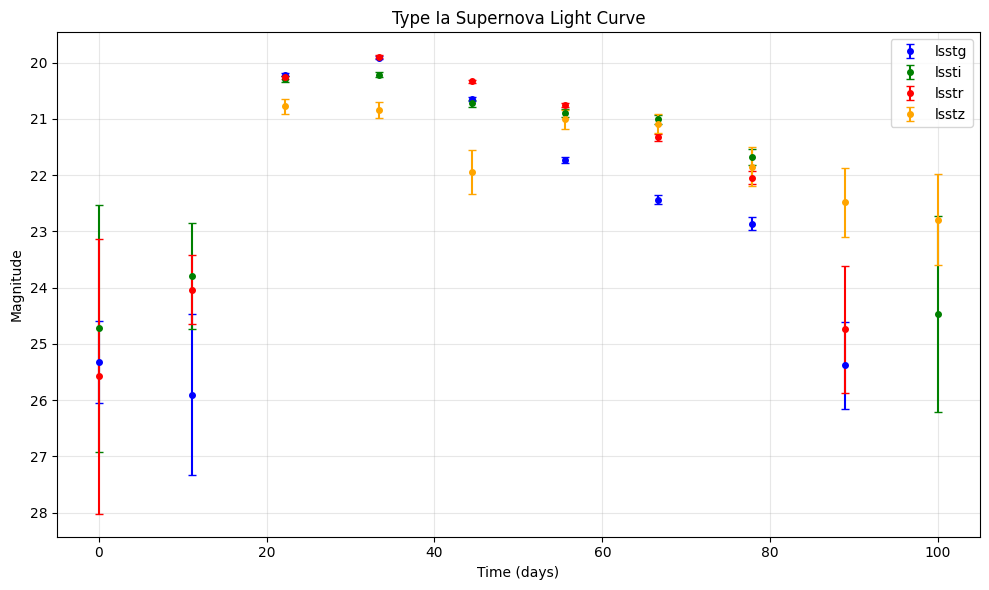

In [19]:
lcs = main()

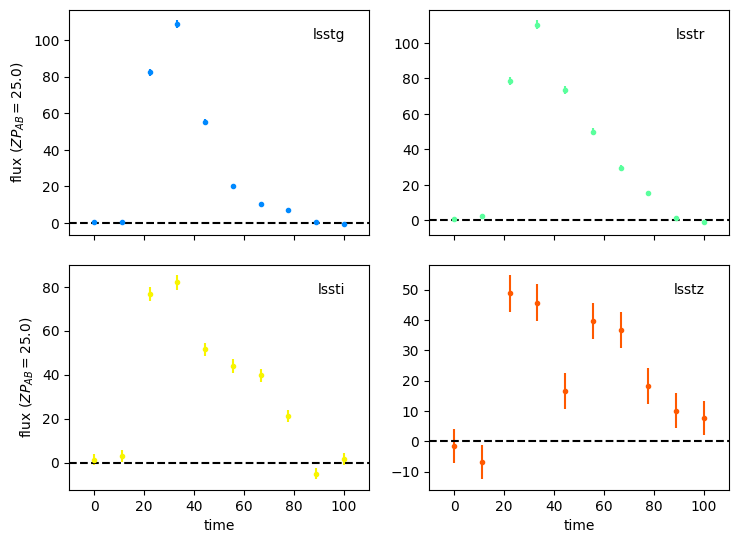

In [20]:
sncosmo.plot_lc(lcs[0]);

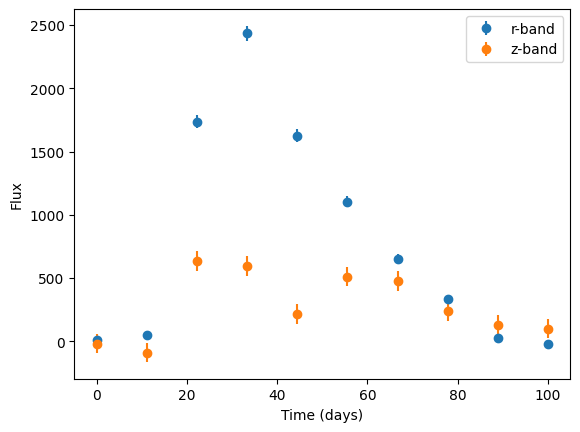

In [21]:
r_band_mask = lcs[0]['band'] == 'lsstr'
z_band_mask = lcs[0]['band'] == 'lsstz'


plt.errorbar(lcs[0]['time'][r_band_mask], lcs[0]['flux'][r_band_mask], yerr=lcs[0]['fluxerr'][r_band_mask], fmt='o', label='r-band')
plt.errorbar(lcs[0]['time'][z_band_mask], lcs[0]['flux'][z_band_mask], yerr=lcs[0]['fluxerr'][z_band_mask], fmt='o', label='z-band')
plt.xlabel('Time (days)')
plt.ylabel('Flux')
plt.legend()
plt.show()

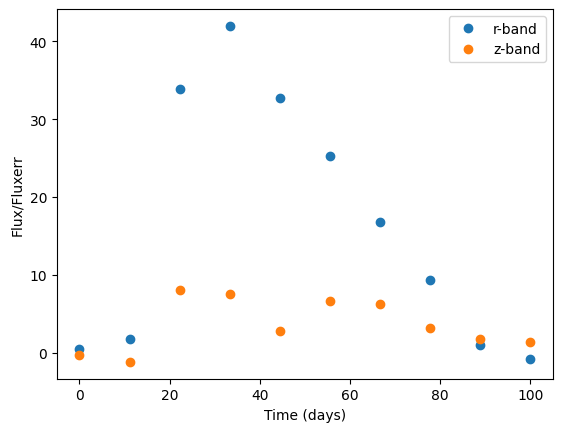

In [23]:
plt.errorbar(lcs[0]['time'][r_band_mask], lcs[0]['flux'][r_band_mask]/lcs[0]['fluxerr'][r_band_mask], fmt='o', label='r-band')
plt.errorbar(lcs[0]['time'][z_band_mask], lcs[0]['flux'][z_band_mask]/lcs[0]['fluxerr'][z_band_mask], fmt='o', label='z-band')
plt.xlabel('Time (days)')
plt.ylabel('Flux/Fluxerr')
plt.legend()
plt.show()

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn.mixture import GaussianMixture


rng = np.random.default_rng()

In [93]:
class SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej', 'log_vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_dict):
        self.true_class = true_class
        if self.true_class == 'ia':
            self.true_params = {key:true_dict[key] for key in self.ia_keys}
        elif self.true_class == 'ibc':
            self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        else:
            raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}
        self.ibc_fit.update({'log_vej': np.log10(self.ibc_fit['vej'])})

In [118]:
data = np.load("fitted_sne_100_092425.npz", allow_pickle=True)
true_ia_sne = data['ia']
true_ibc_sne = data['ibc']
all_sne = np.concatenate((true_ia_sne, true_ibc_sne))
len(true_ibc_sne), len(all_sne)


(100, 200)

In [119]:
for sn in all_sne:
    sn.ibc_fit.update({'log_vej': np.log10(sn.ibc_fit['vej'])})

In [120]:
all_sne

array([<__main__.SN object at 0x16408b460>,
       <__main__.SN object at 0x15c6367d0>], dtype=object)

In [121]:
all_sne[100].true_class

'ibc'

In [122]:
[all_sne[i].true_params for i in range(101,110)]

[{'z': 0.214,
  'texp': 4.952184700157122,
  'mej': 7.0326,
  'fni': 0.1026,
  'vej': 10690.863926169728},
 {'z': 0.175,
  'texp': 4.57056621771739,
  'mej': 6.2457,
  'fni': 0.0856,
  'vej': 10013.272631574178},
 {'z': 0.268,
  'texp': 3.347785883269544,
  'mej': 9.8593,
  'fni': 0.145,
  'vej': 9184.71104631547},
 {'z': 0.276,
  'texp': 6.832678837626833,
  'mej': 7.5367,
  'fni': 0.1377,
  'vej': 7416.411383180844},
 {'z': 0.192,
  'texp': 1.700693172553942,
  'mej': 4.7711,
  'fni': 0.1039,
  'vej': 11776.231098083292},
 {'z': 0.19,
  'texp': 2.458526776400203,
  'mej': 4.5871,
  'fni': 0.0931,
  'vej': 8095.727773637579},
 {'z': 0.198,
  'texp': 1.9667179502231704,
  'mej': 7.4094,
  'fni': 0.0987,
  'vej': 5542.223181955493},
 {'z': 0.23,
  'texp': 6.412389267178473,
  'mej': 7.0326,
  'fni': 0.1026,
  'vej': 10690.863926169728},
 {'z': 0.084,
  'texp': 3.5787404689238143,
  'mej': 6.9148,
  'fni': 0.019,
  'vej': 6662.590938822444}]

In [123]:
for sn in all_sne:
    sn.ibc_fit.update({'log_vej': np.log10(sn.ibc_fit['vej'])})

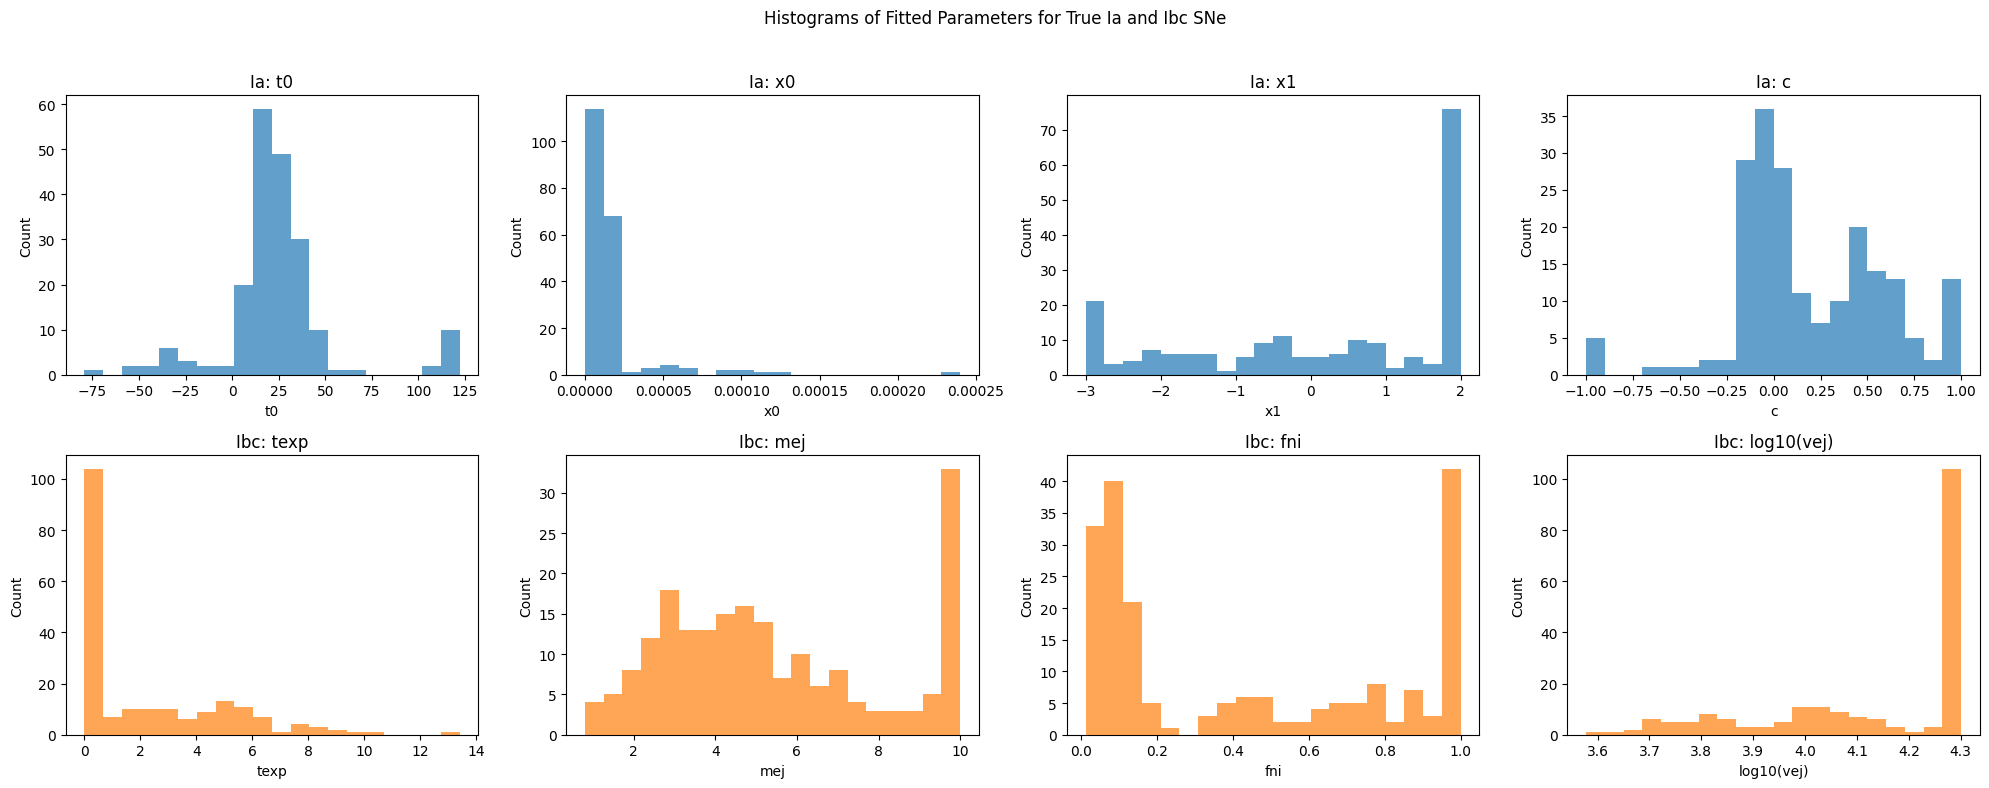

In [124]:
ia_param_names = SN.ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = SN.ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names):
    values = [sn.ia_fit[param] for sn in all_sne if sn.ia_fit[param] is not None]
    axes[0, i].hist(values, bins=20, color='tab:blue', alpha=0.7)
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    values = [sn.ibc_fit[param] for sn in all_sne if sn.ibc_fit[param] is not None]
    if param == 'vej':
        # Plot log10 for vej
        values = [np.log10(v) for v in values if v > 0]
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

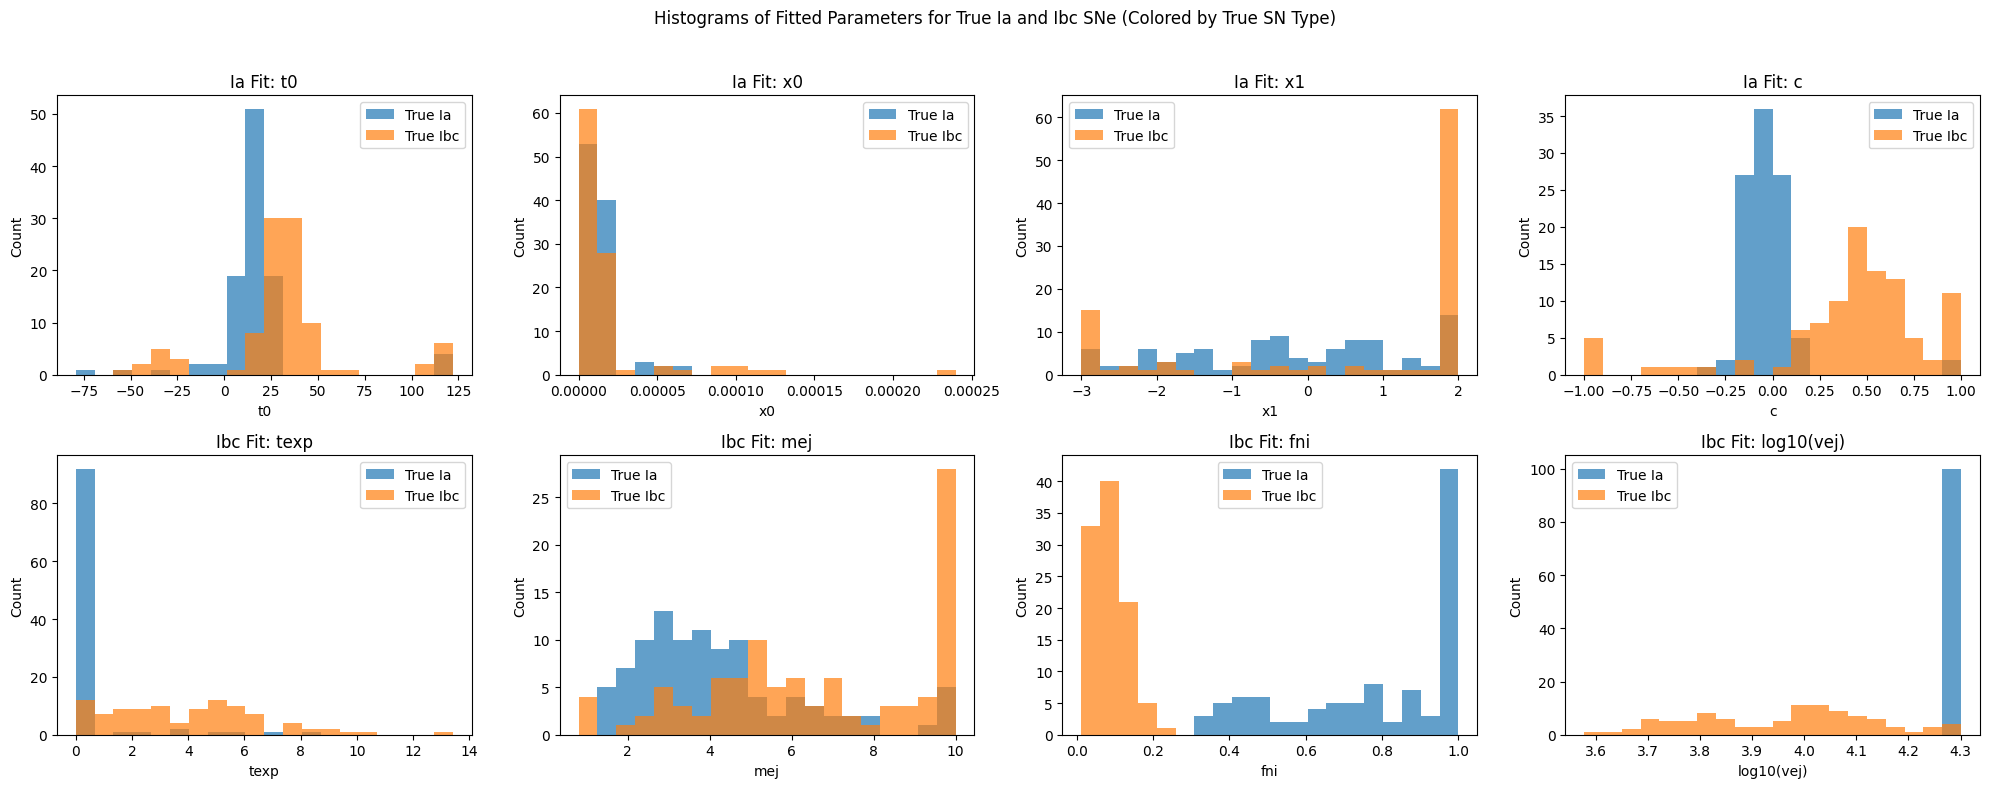

In [125]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe (Colored by True SN Type)")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names):
    ia_values = [sn.ia_fit[param] for sn in true_ia_sne if sn.ia_fit[param] is not None]
    ibc_values = [sn.ia_fit[param] for sn in true_ibc_sne if sn.ia_fit[param] is not None]
    all_values = ia_values + ibc_values
    bins = np.histogram_bin_edges(all_values, bins=20)
    axes[0, i].hist(ia_values, bins=bins, color='tab:blue', alpha=0.7, label='True Ia')
    axes[0, i].hist(ibc_values, bins=bins, color='tab:orange', alpha=0.7, label='True Ibc')
    axes[0, i].set_title(f"Ia Fit: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")
    axes[0, i].legend()

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    ia_values = [sn.ibc_fit[param] for sn in true_ia_sne if sn.ibc_fit[param] is not None]
    ibc_values = [sn.ibc_fit[param] for sn in true_ibc_sne if sn.ibc_fit[param] is not None]
    if param == 'vej':
        ia_values = [np.log10(v) for v in ia_values if v > 0]
        ibc_values = [np.log10(v) for v in ibc_values if v > 0]
    all_values = ia_values + ibc_values
    bins = np.histogram_bin_edges(all_values, bins=20)
    axes[1, i].hist(ia_values, bins=bins, color='tab:blue', alpha=0.7, label='True Ia')
    axes[1, i].hist(ibc_values, bins=bins, color='tab:orange', alpha=0.7, label='True Ibc')
    if param == 'vej':
        axes[1, i].set_title(f"Ibc Fit: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].set_title(f"Ibc Fit: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")
    axes[1, i].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Here we have 8 parameters that we can use to constrain the mixing fraction

In [98]:
# This is the log likelihood function for the distribution of one parameter 
# assuming a mixture of two Gaussians.
# x is the parameter value, samples are the observed data, and alpha is the mixing fraction
def log_likelihood(x, samples, alpha):
    mu1, sigma1, mu2, sigma2 = x
    first_term = alpha * norm.pdf(samples, mu1, sigma1)
    second_term = (1 - alpha) * norm.pdf(samples, mu2, sigma2)
    return np.sum(np.log(first_term + second_term))

In [99]:
def get_param_samples(param_name):
    if param_name in ia_param_names:
        return np.array([sn.ia_fit[param_name] for sn in all_sne])
    elif param_name in ibc_param_names:
        return np.array([sn.ibc_fit[param_name] for sn in all_sne])
    else:
        raise ValueError(f"Parameter {param_name} not recognized in either Ia or Ibc SNe.")

(array([197.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([4.93223394e-10, 2.77435313e-04, 5.54870132e-04, 8.32304951e-04,
        1.10973977e-03, 1.38717459e-03, 1.66460941e-03, 1.94204423e-03,
        2.21947905e-03, 2.49691387e-03, 2.77434869e-03]),
 <BarContainer object of 10 artists>)

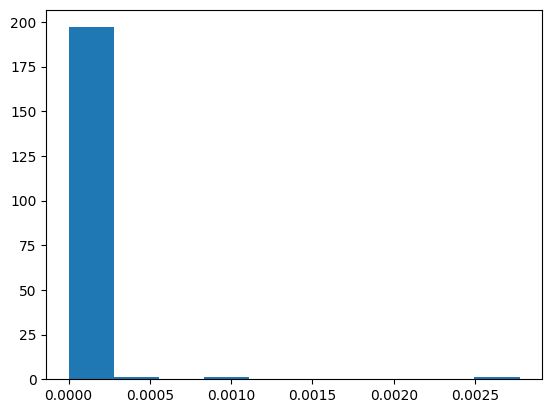

In [100]:
plt.hist(get_param_samples('x0'))

In [101]:
np.shape(get_param_samples('log_vej').reshape(-1, 1))

(200, 1)

In [102]:
# Fit initial guesses
params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'x0', 'fni', 'log_vej']

mus_a = {}
mus_b = {}
sigmas_a = {}
sigmas_b = {}

for param_name in params_to_use:
    samples = get_param_samples(param_name).reshape(-1, 1)
    gm = GaussianMixture(n_components=2).fit(samples)
    mus_a[param_name] = gm.means_[0][0]
    mus_b[param_name] = gm.means_[1][0]
    sigmas_a[param_name] = np.sqrt(gm.covariances_[0][0][0])
    sigmas_b[param_name] = np.sqrt(gm.covariances_[1][0][0])
    print(param_name, gm.weights_)

t0 [0.94500029 0.05499971]
c [0.31770918 0.68229082]
mej [0.62507806 0.37492194]
texp [0.53004739 0.46995261]
x1 [0.36987469 0.63012531]
x0 [9.99892252e-01 1.07748022e-04]
fni [0.49654011 0.50345989]
log_vej [0.53477347 0.46522653]


In [103]:
# from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2).fit(get_param_samples('x1').reshape(-1, 1))
gm.means_, gm.covariances_**0.5, gm.weights_

(array([[ 1.99996131],
        [-0.42504905]]),
 array([[[1.01835975e-03]],
 
        [[1.55341331e+00]]]),
 array([0.36987469, 0.63012531]))

In [104]:
num_epochs = 200
lls = np.zeros(num_epochs)


# mus_a = {'t0': 20, 'x0': 0.0001, 'x1': 2, 'c': 0, 'texp': 0.5, 'mej': 8, 'fni': 0.05, 'log_vej': 4.3}
# mus_b = {'t0': 20, 'x0': 0.0001, 'x1': 0.5, 'c': 0.6, 'texp': 5, 'mej': 2, 'fni': 0.49, 'log_vej': 3.9}
# sigmas_a = {'t0': 10, 'x0': 5e-4, 'x1': 0.01, 'c': 0.1, 'texp': 0.2, 'mej': 2, 'fni': 0.01, 'log_vej': 0.05}
# sigmas_b = {'t0': 10, 'x0': 5e-4, 'x1': 1, 'c': 0.3, 'texp': 3, 'mej': 2, 'fni': 5e-2, 'log_vej': 0.2}


alphas = np.zeros(num_epochs)  # Store alpha values for each epoch
alpha = 0.1  # Mixing fraction
gammas_a = {'texp': [], 'mej': [], 'fni': [], 'log_vej': [], 't0': [], 'x0': [], 'x1': [], 'c': []}
gammas_b = {'texp': [], 'mej': [], 'fni': [], 'log_vej': [], 't0': [], 'x0': [], 'x1': [], 'c': []}

params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'x0', 'fni', 'log_vej']
# params_to_use = list(mus_a.keys())  # Use all parameters for fitting



# there are two populations, a and b
for epoch in range(num_epochs):
    # for param_name in list(mus_a.keys())[:3]:
    for param_name in params_to_use:
        param_samples = get_param_samples(param_name)

        # plt.hist(param_samples)
        # plt.show()

        # print(mus_a[param_name], sigmas_a[param_name])
        # the gammas are weights for every sample
        gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
        gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])
        
        # print(param_name)
        # print(np.sum(gammas_a[param_name]), np.sum(gammas_b[param_name]))
        # print(sum(np.isnan(gammas_a[param_name])), sum(np.isinf(gammas_a[param_name])))

        # Normalize over parameter
        gamma_total = (gammas_a[param_name] + gammas_b[param_name])
        gammas_a[param_name] /= gamma_total
        gammas_b[param_name] /= gamma_total
        

        mus_a[param_name] = np.sum(gammas_a[param_name] * param_samples) / np.sum(gammas_a[param_name])
        mus_b[param_name] = np.sum(gammas_b[param_name] * param_samples) / np.sum(gammas_b[param_name])
        sigmas_a[param_name] = np.sqrt(np.sum(gammas_a[param_name] * (param_samples - mus_a[param_name])**2) / np.sum(gammas_a[param_name]))
        sigmas_b[param_name] = np.sqrt(np.sum(gammas_b[param_name] * (param_samples - mus_b[param_name])**2) / np.sum(gammas_b[param_name]))

    
    # Here we can use information from all parameters to constrain the mixing fraction
    # alpha is the fraction of parameter a, parameter b has 1 - alpha
    alpha = np.mean(np.concatenate([gammas_a[param_name] for param_name in params_to_use]))
    alphas[epoch] = alpha
    print("Alpha", alpha)

    # Calculate log likelihood for the current epoch
    for param_name in params_to_use:
        lls[epoch] += log_likelihood([mus_a[param_name], sigmas_a[param_name], mus_b[param_name], sigmas_b[param_name]], get_param_samples(param_name), alpha)

    

Alpha 0.4543816478527337
Alpha 0.5435769802607159
Alpha 0.6000216059316562
Alpha 0.6140151493756492
Alpha 0.6162294107569655
Alpha 0.6168518683559047
Alpha 0.6173362240876273
Alpha 0.617461627762087
Alpha 0.6170977036677747
Alpha 0.6172286958636931
Alpha 0.6175094553939481
Alpha 0.6176784514209035
Alpha 0.6177351735471359
Alpha 0.6177229150390119
Alpha 0.617682246458503
Alpha 0.6176374459700947
Alpha 0.6175991086107596
Alpha 0.6175700511653964
Alpha 0.6175496420484824
Alpha 0.6175361319419239
Alpha 0.617527689893858
Alpha 0.6175227746327142
Alpha 0.6175202103952304
Alpha 0.6175191500992764
Alpha 0.6175190071413267
Alpha 0.617519388183855
Alpha 0.6175200374833152
Alpha 0.6175207943725358
Alpha 0.6175215622633032
Alpha 0.6175222867384038
Alpha 0.6175229404225778
Alpha 0.6175235127424193
Alpha 0.6175240031210655
Alpha 0.6175244165501705
Alpha 0.6175247607707619
Alpha 0.6175250445402557
Alpha 0.6175252766067283
Alpha 0.6175254651451325
Alpha 0.6175256174820819
Alpha 0.6175257400035997
Alph

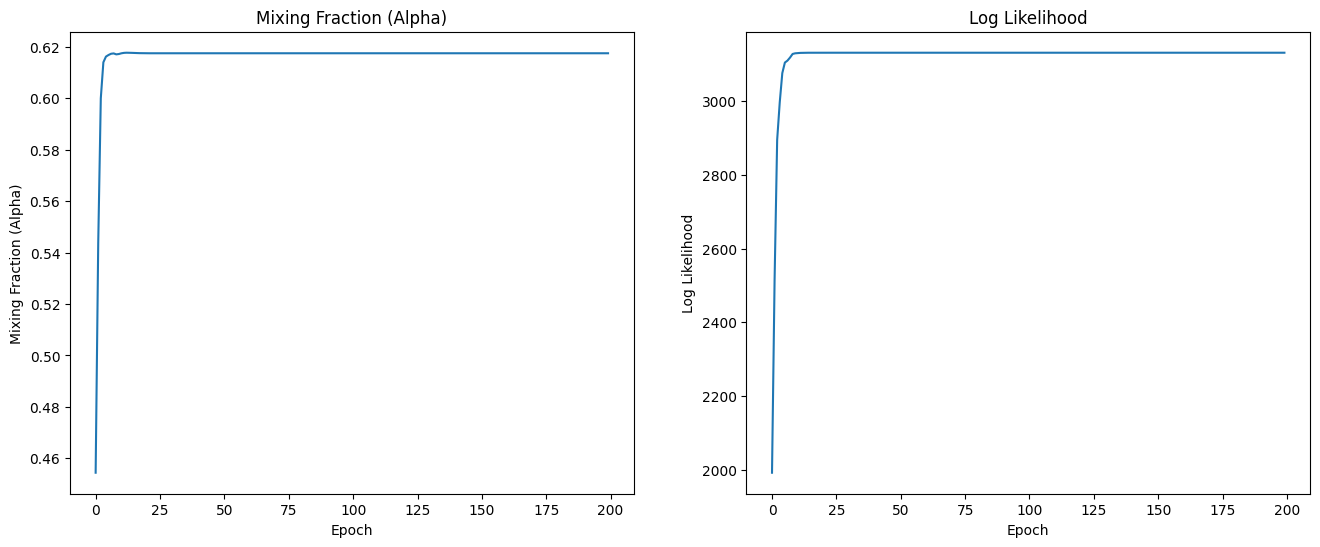

In [105]:
fig, ax = plt.subplots(1,2, figsize=(16, 6))
ax[0].plot(alphas)
ax[1].plot(lls)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Mixing Fraction (Alpha)")
ax[0].set_title("Mixing Fraction (Alpha)")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Log Likelihood")
ax[1].set_title("Log Likelihood")

plt.show()

In [106]:
mus_a, mus_b, sigmas_a, sigmas_b

({'t0': 20.666262844626733,
  'c': 0.10846106924315926,
  'mej': 2.025749397891483,
  'texp': 1.9210854165643913e-06,
  'x1': 1.9999983592653299,
  'x0': 1.1641569747030917e-05,
  'fni': 0.9336461159445086,
  'log_vej': 4.301029931047487},
 {'t0': 115.8395493044568,
  'c': 0.18629358784493874,
  'mej': 7.720308734161564,
  'texp': 3.8906260700556787,
  'x1': -0.2974995613869231,
  'x0': 0.0003626924375952131,
  'fni': 0.09469983037334403,
  'log_vej': 3.9636841374463128},
 {'t0': 17.465993096059726,
  'c': 0.21795211075191445,
  'mej': 0.8656138037060516,
  'texp': 2.7486703660425396e-06,
  'x1': 2.8797475175243075e-06,
  'x0': 3.607438572658854e-06,
  'fni': 0.1643804654163685,
  'log_vej': 9.98313358223823e-08},
 {'t0': 4.235483370559099,
  'c': 0.5046149836504003,
  'mej': 2.093575094668733,
  'texp': 2.38469257484712,
  'x1': 1.605971824159543,
  'x0': 0.0006986166673293498,
  'fni': 0.05696639556482579,
  'log_vej': 0.16191642149011448})

In [107]:
for n in sigmas_b.keys():
    if sigmas_b[n] <= 0.01:
        sigmas_b[n] = 0.01

for n in sigmas_a.keys():
    if sigmas_a[n] <= 0.01:
        sigmas_a[n] = 0.01

[24.50999023 24.51246997 24.5149252  24.51735591 24.51976209 24.52214374
 24.52450085 24.52683341 24.52914142 24.53142487 24.53368375 24.53591805
 24.53812778 24.54031291 24.54247345 24.54460938 24.54672071 24.54880743
 24.55086952 24.55290699 24.55491982 24.55690801 24.55887156 24.56081046
 24.5627247  24.56461427 24.56647918 24.56831942 24.57013497 24.57192584
 24.57369202 24.5754335  24.57715028 24.57884235 24.58050971 24.58215236
 24.58377028 24.58536348 24.58693195 24.58847567 24.58999466 24.59148891
 24.5929584  24.59440314 24.59582312 24.59721834 24.59858879 24.59993446
 24.60125537 24.60255149 24.60382283 24.60506938 24.60629114 24.60748811
 24.60866028 24.60980764 24.6109302  24.61202796 24.6131009  24.61414902
 24.61517233 24.61617081 24.61714447 24.6180933  24.6190173  24.61991647
 24.6207908  24.6216403  24.62246495 24.62326476 24.62403972 24.62478984
 24.6255151  24.62621551 24.62689106 24.62754176 24.6281676  24.62876858
 24.62934469 24.62989594 24.63042233 24.63092384 24

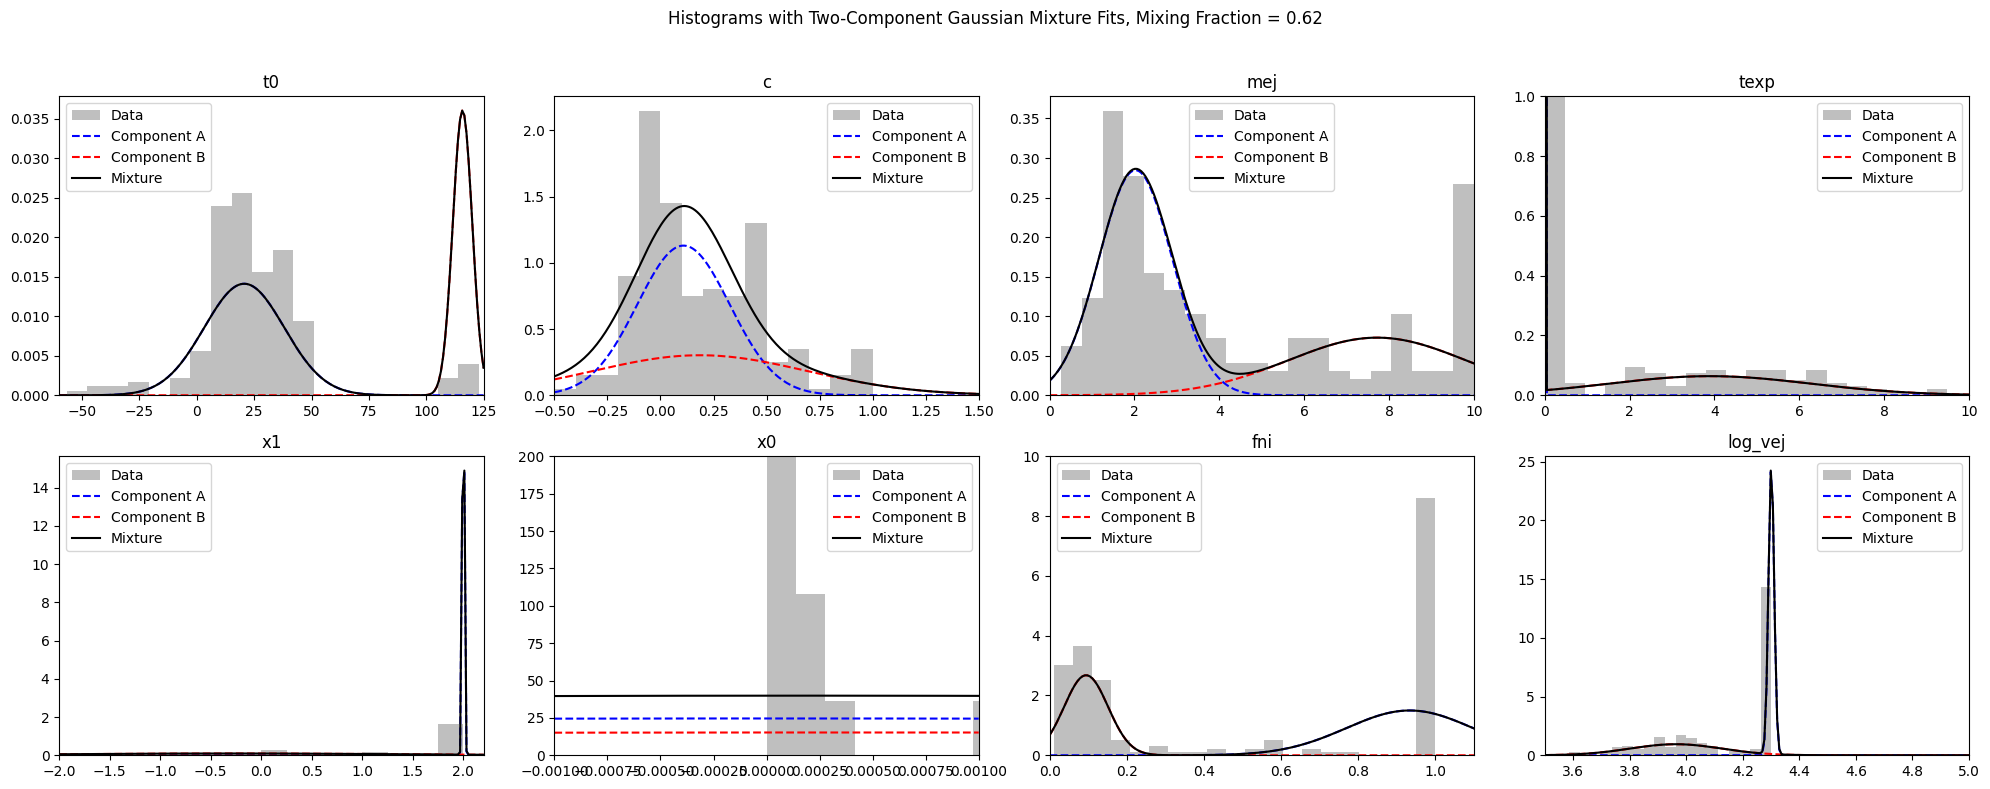

In [108]:
x_ranges = {
    't0': np.linspace(-60, 125, 200),
    'x0': np.linspace(-0.001, 0.001, 200),  # Expanded range for x0
    'x1': np.linspace(-2, 2.2, 200),
    'c': np.linspace(-0.5, 1.5, 200),
    'texp': np.linspace(0, 10, 200),
    'mej': np.linspace(0, 10, 200),
    'fni': np.linspace(0, 1.3, 200),
    'log_vej': np.linspace(3.5, 5, 200)
}

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms with Two-Component Gaussian Mixture Fits, Mixing Fraction = {:.2f}".format(alpha))

for idx, param in enumerate(params_to_use):
    samples = get_param_samples(param)
    ax = axes.flat[idx]
    ax.hist(samples, bins=20, density=True, alpha=0.5, color='gray', label='Data')
    x = x_ranges[param]
    # Mixture fit
    y_a = alpha * norm.pdf(x, mus_a[param], sigmas_a[param])
    y_b = (1 - alpha) * norm.pdf(x, mus_b[param], sigmas_b[param])
    y_mix = y_a + y_b
    if param == 'x0':
        print(y_a)
    ax.plot(x, y_a, 'b--', label='Component A')
    ax.plot(x, y_b, 'r--', label='Component B')
    ax.plot(x, y_mix, 'k-', label='Mixture')
    ax.set_title(param)
    ax.set_xlim(x[0], x[-1])  # Ensure curves span the full x range
    if param == 'texp':
        ax.set_ylim(0, 1)
    elif param == 'fni':
        ax.set_ylim(0, 10)
        ax.set_xlim(0, 1.1)
    elif param == 'x0':
        ax.set_ylim(0, 200)
        ax.set_xlim(-0.001, 0.001)  # Expanded
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

(array([187.,   4.,   2.,   2.,   3.,   0.,   1.,   0.,   0.,   1.]),
 array([1.09204827e-14, 2.74918796e-05, 5.49837591e-05, 8.24756387e-05,
        1.09967518e-04, 1.37459398e-04, 1.64951277e-04, 1.92443157e-04,
        2.19935036e-04, 2.47426916e-04, 2.74918796e-04]),
 <BarContainer object of 10 artists>)

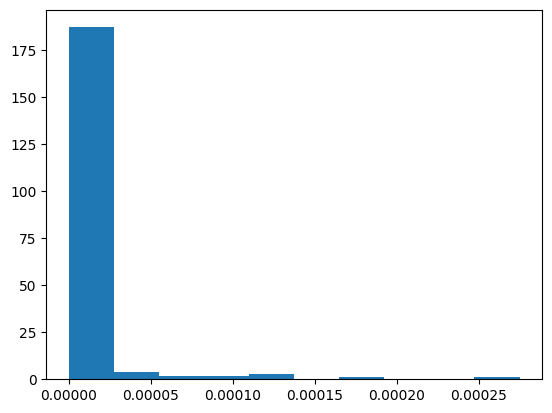

In [91]:
plt.hist(get_param_samples('x0'))